In [1]:
import tensorflow as tf

# load the model used for prediction the external contour
ex_cnt_model = tf.keras.models.load_model('unet_model')
in_cnt_model = tf.keras.models.load_model('internal_smaller_mask_unet_model')

In [2]:
# load the image
original_images_dir = 'data/original/'
heatmap_images_dir = 'data/heatmap/'

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_contour(mask: np.ndarray):
     # Apply thresholding
    ret, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    # sDefine structuring element (MORPH_RECT)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    # Erosion using MORPH_RECT structuring element
    erosion= cv2.erode(thresh, kernel, iterations=1)
    # Dilate using MORPH_RECT structuring element
    dilation = cv2.dilate(erosion, kernel, iterations=1)
    # Find contour using the eroded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Find the contour with the largest area
    contour = max(contours, key=cv2.contourArea)
    return contour

def predict_mask(img, model):
    # Predict the mask
    img = cv2.resize(img, (128, 128))
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)
    img = img / 255
    pred = model.predict(img)
    pred = tf.argmax(pred, axis=-1)
    pred = pred[..., tf.newaxis]
    pred = tf.squeeze(pred)
    pred = pred.numpy()
    pred = pred.astype(np.uint8) * 255
    return pred

1/1 [==============================] - 1s 955ms/step
Major axis (b): 1968.0 pixels
Minor axis (a): 2048.0 pixels
Radius (D): 3772.73 pixels
Farthest distance (h): 1028.49 pixels


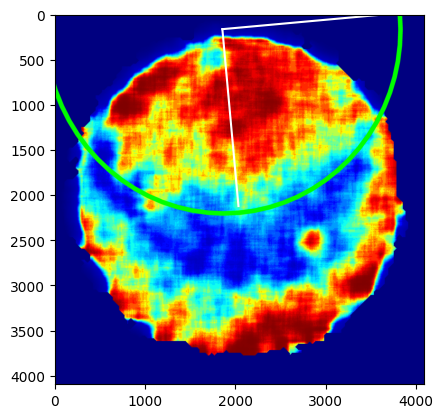

In [4]:
import cv2
import numpy as np
from shapely.geometry import Polygon

def read_image(file_path):
    return cv2.imread(file_path)

def find_center_of_mass(contour):
    # Find the center of mass of the contour
    hull = cv2.convexHull(contour)
    ellipse = cv2.fitEllipse(hull)
    (x, y), (MA, ma), angle = ellipse
    return (int(x), int(y))

def find_center_of_mass2(contour):
    # Find the center of mass of the contour
    M = cv2.minEnclosingCircle(contour)
    return (int(M[0][0]), int(M[0][1]))

def calculate_vector(center1, center2):
    return (center2[0] - center1[0], center2[1] - center1[1])

def is_point_near_line(point, line_start, line_end, eps1):
    # Convert tuples to numpy arrays
    point = np.array(point)
    line_start = np.array(line_start)
    line_end = np.array(line_end)

    # Calculate the directional vector of the line
    line_vec = line_end - line_start

    # Calculate the vector from the start of the line to the point
    point_vec = point - line_start

    # Calculate the cross product and the norm
    cross_prod = np.cross(line_vec, point_vec)
    norm_line_vec = np.linalg.norm(line_vec)

    # Calculate the distance from the point to the line
    distance = np.linalg.norm(cross_prod) / norm_line_vec

    # Check if the distance is within the threshold
    return abs(distance) <= eps1

def find_points_near_line(points, line_start, line_end, eps1):
    step=0.1
    max_eps=100
    # Initialize an empty list to store points near the line
    points_near_line = []

    # Temporary variable for the current eps1 value
    current_eps = eps1

    # Loop until at least one point is found or max_eps is reached
    while len(points_near_line) < 1000  and current_eps <= max_eps:
        # Iterate through each point in the list
        for point in points:
            # Check if the point is near the line
            if is_point_near_line(point, line_start, line_end, current_eps):
                # If the point is near the line, add it to the list
                points_near_line.append(point)

        # Increase current_eps for the next iteration
        current_eps += step

    # Return the list of points near the line as a numpy array
    return np.array(points_near_line)

def is_point_on_left_or_right_side(point, line_start, line_end):
    # Convert tuples to numpy arrays
    point = np.array(point)
    line_start = np.array(line_start)
    line_end = np.array(line_end)

    # Calculate the vector representing the original line
    original_line_vector = line_end - line_start

    # Calculate the orthogonal line vector (rotate original line by 90 degrees)
    orthogonal_line_vector = np.array([-original_line_vector[1], original_line_vector[0]])

    # Define the end point of the new line, extending the orthogonal line from line_start
    new_line_end = line_start + orthogonal_line_vector

    # Calculate the vector from the start of the new line to the point
    point_vector = point - line_start

    # Calculate the vector representing the new line
    new_line_vector = new_line_end - line_start

    # Calculate the cross product (in 2D, it's a scalar)
    cross_prod = np.cross(new_line_vector, point_vector)

    # Determine the side based on the sign of the cross product
    if cross_prod > 0:
        return 'left'
    else:
        return 'right'

def find_farthest_point(contour, center, axis_angle):
    """Find the farthest point on the contour from the center along a specified axis."""
    farthest_distance = 0
    for point in contour:
        # Project each point onto the specified axis
        vector = np.array(point[0]) - np.array(center)
        axis_vector = np.array([np.cos(np.radians(axis_angle)), np.sin(np.radians(axis_angle))])
        distance = np.dot(vector, axis_vector)
        farthest_distance = max(farthest_distance, abs(distance))
    return farthest_distance

def adjust_ellipse(contour, new_center, vector, step_size=1, max_iterations=1000):
    new_center = new_center[0]
    # Fit initial ellipse
    ellipse = cv2.fitEllipse(contour)
    (x, y), (MA, ma), angle = ellipse
    # use the vector to find the angle of rotation, and if angle is negative, add 180 degrees
    # if np.arctan2(vector[1], vector[0]) < 0:
    #     # use vector to find the angle of rotation
    #     angle = 0 + np.degrees(np.arctan2(vector[1], vector[0]))
    # else:
    #    angle = 180 + np.degrees(np.arctan2(vector[1], vector[0]))

    angle = np.degrees(np.arctan2(vector[1], vector[0]))

    # Calculate the farthest point on the contour from the center along the specified axis
    farthest_distance = find_farthest_point(contour, new_center, angle)

    # Calculate new major and minor axes lengths
    new_major_axis = ma * (ma / MA)
    new_minor_axis = farthest_distance  * 2

    # Update the ellipse with the new parameters
    ellipse = (new_center, (new_minor_axis, new_major_axis), angle)

    return ellipse, farthest_distance

def find_ellipse(in_cnt, ex_cnt):
    ex_cnt_center = find_center_of_mass2(ex_cnt)
    in_cnt_center = find_center_of_mass(in_cnt)

    vector = calculate_vector(ex_cnt_center, in_cnt_center)

    # Find points near the line
    eps1 = 0.1
    points_near_line = find_points_near_line(ex_cnt, ex_cnt_center, in_cnt_center, eps1)

    # Find points on the left and right side of the line
    left_points = []
    right_points = []
    for point in points_near_line:
        if is_point_on_left_or_right_side(point, ex_cnt_center, in_cnt_center) == 'left':
            left_points.append(point)
        else:
            right_points.append(point)

    left_points = np.array(left_points)
    right_points = np.array(right_points)

    # Check if the center of mass of the internal contour is on the left or right side of the line
    side = is_point_on_left_or_right_side(in_cnt_center, ex_cnt_center, in_cnt_center)
    if side == 'left':
        points = left_points
    else:
        points = right_points

    sample_point = points[0]

    ellipse, farthest_distance = adjust_ellipse(in_cnt, sample_point, vector)

    return ellipse, farthest_distance


# Main processing
original_img = read_image(original_images_dir + 'test/P3MF10_N.png')
heatmap_img = read_image(heatmap_images_dir + 'test/P3MF10_N.png')
ex_cnt_mask = predict_mask(original_img, ex_cnt_model)
in_cnt_mask = predict_mask(heatmap_img, in_cnt_model)
ex_cnt = get_contour(ex_cnt_mask)
in_cnt = get_contour(in_cnt_mask)
ellipse, farthest_distance = find_ellipse(in_cnt, ex_cnt)
#convert tuple ellpipse to integer
ellipse = (tuple(map(int, ellipse[0])), tuple(map(int, ellipse[1])), ellipse[2])

factor = int(original_img.shape[0] / 128)
scaled_ellipse = ((ellipse[0][0] * factor, ellipse[0][1] * factor), (ellipse[1][0] * factor, ellipse[1][1] * factor), ellipse[2])
# Drawing the ellipse
ellipse_img = heatmap_img.copy()
cv2.ellipse(ellipse_img, scaled_ellipse, (0, 255, 0), 50)

# Find the radius of the circle of the external contour
radius = cv2.minEnclosingCircle(ex_cnt)[1]

# Add a description to the image with the ellipse major and minor axes lengths outside image
text = 'Major axis (b): ' + str(round(scaled_ellipse[1][1] / 2, 2)) + ' pixels'
text += '\nMinor axis (a): ' + str(round(scaled_ellipse[1][0] / 2, 2)) + ' pixels'
text += '\nRadius (D): ' + str(round(radius * factor * 2, 2)) + ' pixels'
text += '\nFarthest distance (h): ' + str(round(farthest_distance * factor / 2.0, 2)) + ' pixels'
print(text)


# plot the major and minor axes of the ellipse
# plot major_axis in the opposite direction
plt.plot([scaled_ellipse[0][0], scaled_ellipse[0][0] + scaled_ellipse[1][1] / 2 * np.cos(np.radians(scaled_ellipse[2] + 180))], [scaled_ellipse[0][1], scaled_ellipse[0][1] + scaled_ellipse[1][1] / 2 * np.sin(np.radians(scaled_ellipse[2] + 180))], c='w')
# plot minor_axis
plt.plot([scaled_ellipse[0][0], scaled_ellipse[0][0] + scaled_ellipse[1][0] / 2 * np.cos(np.radians(scaled_ellipse[2] + 90))], [scaled_ellipse[0][1], scaled_ellipse[0][1] + scaled_ellipse[1][0] / 2 * np.sin(np.radians(scaled_ellipse[2] + 90))], c='w')


# # plt the center of mass of the internal contour
# in_cnt_center = find_center_of_mass(in_cnt)
# plt.scatter(in_cnt_center[0] * factor, in_cnt_center[1] * factor, c='w', s=50)
# ex_cnt_center = find_center_of_mass(ex_cnt)
# plt.scatter(ex_cnt_center[0] * factor, ex_cnt_center[1] * factor, c='w', s=50)




# Show the image
ellipse_img = cv2.cvtColor(ellipse_img, cv2.COLOR_BGR2RGB)
plt.imshow(ellipse_img)
plt.show()

In [6]:
import os
directories = ['test', 'train']

# Create an pdf file to save the results
from fpdf import FPDF
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size=12)

i = 0
for directory in directories:
    for img_name in os.listdir(original_images_dir + directory):
        original_img = read_image(original_images_dir + directory + '/' + img_name)
        heatmap_img = read_image(heatmap_images_dir + directory + '/' + img_name)
        ex_cnt_mask = predict_mask(original_img, ex_cnt_model)
        in_cnt_mask = predict_mask(heatmap_img, in_cnt_model)
        ex_cnt = get_contour(ex_cnt_mask)
        in_cnt = get_contour(in_cnt_mask)
        ellipse, farthest_distance = find_ellipse(in_cnt, ex_cnt)
        #convert tuple ellpipse to integer
        ellipse = (tuple(map(int, ellipse[0])), tuple(map(int, ellipse[1])), ellipse[2])
        factor = int(original_img.shape[0] / 128)
        scaled_ellipse = ((ellipse[0][0] * factor, ellipse[0][1] * factor), (ellipse[1][0] * factor, ellipse[1][1] * factor), ellipse[2])
        ex_cnt = cv2.convexHull(ex_cnt)
        in_cnt = cv2.convexHull(in_cnt)
        ex_cnt = ex_cnt.astype(np.int32)
        in_cnt = in_cnt.astype(np.int32)
        ex_cnt = ex_cnt * factor
        in_cnt = in_cnt * factor
        # Drawing the ellipse
        ellipse_img = heatmap_img.copy()
        cv2.ellipse(ellipse_img, scaled_ellipse, (0, 255, 0), 50)

        # Find the radius of the circle of the external contour
        radius = cv2.minEnclosingCircle(ex_cnt)[1]

        # Add a description to the image with the ellipse major and minor axes lengths outside image
        text = 'a: ' + str(round(scaled_ellipse[1][0] / 2, 2)) + ' pixels'
        text += ' b: ' + str(round(scaled_ellipse[1][1] / 2, 2)) + ' pixels'
        text += ' D: ' + str(round(radius * 2, 2)) + ' pixels'
        text += ' h: ' + str(round(farthest_distance * factor / 2.0, 2)) + ' pixels'

        # Drawing the major axis of the ellipse
        cv2.line(
            ellipse_img,
            (int(scaled_ellipse[0][0]), int(scaled_ellipse[0][1])),
            (int(scaled_ellipse[0][0] + scaled_ellipse[1][1] / 2 * np.cos(np.radians(scaled_ellipse[2] + 270))),
             int(scaled_ellipse[0][1] + scaled_ellipse[1][1] / 2 * np.sin(np.radians(scaled_ellipse[2] + 270)))),
            (0, 0, 255),
            50
        )

        # Drawing the minor axis of the ellipse
        cv2.line(
            ellipse_img,
            (int(scaled_ellipse[0][0]), int(scaled_ellipse[0][1])),
            (int(scaled_ellipse[0][0] + scaled_ellipse[1][0] / 2 * np.cos(np.radians(scaled_ellipse[2] + 180))),
             int(scaled_ellipse[0][1] + scaled_ellipse[1][0] / 2 * np.sin(np.radians(scaled_ellipse[2] + 180)))),
            (0, 0, 255),
            50
        )


        # plt.show()
        pdf.cell(200, 10, txt=img_name, ln=1, align="C")
        pdf.cell(200, 50, txt=text, ln=0.5, align="C")
        # reduce the size of the image
        ellipse_img = cv2.resize(ellipse_img, (0, 0), fx=0.5, fy=0.5)
        # Save the image in tmp file
        cv2.imwrite('tmp' + str(i) + '.png', ellipse_img)
        # Add the image to pdf file
        pdf.image('tmp' + str(i) + '.png', x=50, y=60, w=100)
        # Add new page
        pdf.add_page()
        i += 1
# Delete the tmp files
for i in range(i):
    os.remove('tmp' + str(i) + '.png')
pdf.output("ellipse1.pdf")


1/1 [==============================] - 0s 49ms/step


''

In [ ]:
import os
directories = ['test', 'train']

# Create an CSV file to save the results of the area of the external & internal contour
import csv
with open('contour_areas.csv', mode='w') as csv_file:
    fieldnames = ['img_name', 'ex_cnt_area', 'in_cnt_area']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for directory in directories:
        for img_name in os.listdir(original_images_dir + directory):
            original_img = read_image(original_images_dir + directory + '/' + img_name)
            heatmap_img = read_image(heatmap_images_dir + directory + '/' + img_name)
            ex_cnt_mask = predict_mask(original_img, ex_cnt_model)
            in_cnt_mask = predict_mask(heatmap_img, in_cnt_model)
            ex_cnt = get_contour(ex_cnt_mask)
            in_cnt = get_contour(in_cnt_mask)
            factor = int(original_img.shape[0] / 128)
            ex_cnt = cv2.convexHull(ex_cnt)
            in_cnt = cv2.convexHull(in_cnt)
            ex_cnt = ex_cnt.astype(np.int32)
            in_cnt = in_cnt.astype(np.int32)
            ex_cnt = ex_cnt * factor
            in_cnt = in_cnt * factor
            ex_cnt_area = cv2.contourArea(ex_cnt)
            in_cnt_area = cv2.contourArea(in_cnt)
            # Insert another row in the CSV file with the filename and the area of the external & internal contour
            writer.writerow({'img_name': img_name, 'ex_cnt_area': round(ex_cnt_area, 2), 'in_cnt_area': round(in_cnt_area, 2)})
            


In [5]:
# define a matrix called M
M =  np.array([[[ 1.095000e+00, -1.177000e+00,  7.250000e-01],
         [-1.336000e+00,  1.792400e+01, -1.742700e+01],
         [ 1.310800e+01, -1.372520e+02,  1.346520e+02],
         [-4.368900e+01,  5.458160e+02, -5.519020e+02],
         [ 1.348680e+02, -1.223334e+03,  1.239493e+03],
         [-2.426530e+02,  1.541587e+03, -1.548537e+03],
         [ 2.540930e+02, -1.006656e+03,  9.693880e+02],
         [-1.081960e+02,  2.642060e+02, -2.271320e+02]],

        [[ 1.130000e-01,  2.710000e-01, -3.880000e-01],
         [ 1.824000e+00, -1.164900e+01,  1.007400e+01],
         [-2.170900e+01,  9.835800e+01, -8.008800e+01],
         [ 1.054830e+02, -4.150270e+02,  3.281650e+02],
         [-2.712250e+02,  9.827130e+02, -7.729210e+02],
         [ 3.874700e+02, -1.329634e+03,  1.055952e+03],
         [-2.900240e+02,  9.618930e+02, -7.845810e+02],
         [ 8.838700e+01, -2.885650e+02,  2.457980e+02]],

        [[-8.960000e-01,  9.040000e-01,  8.000000e-03],
         [ 3.092000e+00,  7.010000e-01, -4.883000e+00],
         [-4.197000e+00, -3.264100e+01,  5.509200e+01],
         [-1.325500e+01,  2.041040e+02, -3.050790e+02],
         [ 5.154800e+01, -5.684070e+02,  9.169620e+02],
         [-5.932900e+01,  8.575430e+02, -1.545428e+03],
         [ 1.348100e+01, -6.576590e+02,  1.372595e+03],
         [ 1.085400e+01,  1.915700e+02, -4.855560e+02]]])

In [12]:
import os
directories = ['test', 'train']

# Create an CSV file to save the results of the area of the external & internal contour
import csv
with open('crack_growth_calc.csv', mode='w') as csv_file:
    fieldnames = ['img_name', 'ex_cnt_area', 'in_cnt_area', 'a', 'b', 'D', 'F1 at the middle of the crack front', 'F1 at the edge of the crack front']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    i = 0
    for directory in directories:
        for img_name in os.listdir(original_images_dir + directory):
            original_img = read_image(original_images_dir + directory + '/' + img_name)
            heatmap_img = read_image(heatmap_images_dir + directory + '/' + img_name)
            ex_cnt_mask = predict_mask(original_img, ex_cnt_model)
            in_cnt_mask = predict_mask(heatmap_img, in_cnt_model)
            ex_cnt = get_contour(ex_cnt_mask)
            in_cnt = get_contour(in_cnt_mask)
            ellipse, farthest_distance = find_ellipse(in_cnt, ex_cnt)
            #convert tuple ellpipse to integer
            ellipse = (tuple(map(int, ellipse[0])), tuple(map(int, ellipse[1])), ellipse[2])
            factor = int(original_img.shape[0] / 128)
            scaled_ellipse = ((ellipse[0][0] * factor, ellipse[0][1] * factor), (ellipse[1][0] * factor, ellipse[1][1] * factor), ellipse[2])
            ex_cnt = cv2.convexHull(ex_cnt)
            in_cnt = cv2.convexHull(in_cnt)
            ex_cnt = ex_cnt.astype(np.int32)
            in_cnt = in_cnt.astype(np.int32)
            ex_cnt = ex_cnt * factor
            in_cnt = in_cnt * factor
            # Drawing the ellipse
            ellipse_img = heatmap_img.copy()
            cv2.ellipse(ellipse_img, scaled_ellipse, (0, 255, 0), 50)

            # Find the radius of the circle of the external contour
            radius = cv2.minEnclosingCircle(ex_cnt)[1]

            a = round(scaled_ellipse[1][0] / 2, 2)
            b = round(scaled_ellipse[1][1] / 2, 2)
            D = round(radius * 2, 2)

            K_c = 0
            F1 = 0
            sigma = 634

            for i in range(3):
                for j in range(8):
                    for k in range(3):
                        a_div_b = a / b
                        if a_div_b > 1:
                            a_div_b = 1
                        F1 += M[i][j][k] * ((a_div_b ** i) * ((a / D) ** j) * (0 ** k))
            F_c = F1

            K_m = F1 * sigma * np.sqrt(np.pi * a) *  ((5500/4096))
            K_e = 0
            F1 = 0
            sigma = 634

            for i in range(3):
                for j in range(8):
                    for k in range(3):
                        # create a ceil of up to 1 to a/b
                        a_div_b = a / b
                        if a_div_b > 1:
                            a_div_b = 1
                        F1 += M[i][j][k] * ((a_div_b ** i) * ((a / D) ** j) * (1 ** k))
            F_e = F1
            k_e = F1 * sigma * np.sqrt(np.pi * a) * ((5500/4096))

            # add a row with the area of the external & internal contour, a, b, D
            writer.writerow({'img_name': img_name, 'ex_cnt_area': round(cv2.contourArea(ex_cnt), 2), 'in_cnt_area': round(cv2.contourArea(in_cnt), 2), 'a': a, 'b': b, 'D': D, 'F1 at the middle of the crack front': F_c, 'F1 at the edge of the crack front': F_e})

1/1 [==============================] - 0s 49ms/step
